# CSc 74020 Machine Learning Week 3: Bayesian Linear Regression Example

In [1]:
# !pip install --upgrade pandas
!pip install --upgrade pandas-datareader

In [3]:
import numpy as np
import pandas as pd
import pandas_datareader as web
from pandas_datareader import data as pdr
import datetime
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LassoCV
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.metrics import r2_score
from scipy import stats
import random

import matplotlib.pylab as plt

%pylab inline
#%pylab --no-import-all

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


C:\Users\rmcne\anaconda3\lib\site-packages\IPython\core\magics\pylab.py:162: UserWarning: pylab import has clobbered these variables: ['random', 'plt']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


In [4]:
start_date=datetime.datetime(2013,1,1)
end_date=datetime.datetime(2020,12,31)

stock_list=['AAPL','META','IBM','PG','VXX','INTC','GM']
stock_list

['AAPL', 'META', 'IBM', 'PG', 'VXX', 'INTC', 'GM']

In [5]:
#needed due to durrent bug
import yfinance as yf
yf.pdr_override()

C:\Users\rmcne\anaconda3\lib\site-packages\yfinance\base.py:48: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  _empty_series = pd.Series()


In [7]:
#download the data and calculate returns
df_temp=pdr.get_data_yahoo('SPY', start_date, end_date)
df_temp['SPY']=(df_temp['Adj Close']-df_temp['Adj Close'].shift(1))/df_temp['Adj Close'].shift(1)
df_temp=df_temp[1:]
df=df_temp[['SPY']]

df.head()

[*********************100%%**********************]  1 of 1 completed


,SPY
Date,
2013-01-03,-0.002259
2013-01-04,0.004392
2013-01-07,-0.002733
2013-01-08,-0.002877
2013-01-09,0.002542


In [8]:
for stock in stock_list:
    print(stock)
    df_temp=pdr.get_data_yahoo(stock, start_date, end_date)
    df_temp[stock]=(df_temp['Adj Close']-df_temp['Adj Close'].shift(1))/df_temp['Adj Close'].shift(1)
    df_temp=df_temp[1:]
    df_temp=df_temp[[stock]]
    df=df.join(df_temp)

df.head()

AAPL


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


META
IBM


[*********************100%%**********************]  1 of 1 completed


PG


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


VXX
INTC


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

GM


,SPY,AAPL,META,IBM,PG,VXX,INTC,GM
Date,,,,,,,,
2013-01-03,-0.002259,-0.012622,-0.008214,-0.005501,-0.006341,NaN,-0.002806,0.023687
2013-01-04,0.004392,-0.027855,0.035650,-0.006555,0.002031,NaN,-0.007505,0.001341
2013-01-07,-0.002733,-0.005882,0.022949,-0.004382,-0.006803,NaN,0.004253,-0.006698
2013-01-08,-0.002877,0.002691,-0.012237,-0.001398,-0.001604,NaN,-0.007529,-0.009778
2013-01-09,0.002542,-0.015629,0.052650,-0.002851,0.005401,NaN,0.017069,0.020429


Let's fit the regular CAPM model for PG

$$ Return_{PG}(t)=\alpha + \beta * Return_{SPY}(t)+\epsilon$$

In [9]:
slope, intercept, r_value, pval, std_err = stats.linregress(df['SPY'],df['META'])
print(slope, intercept, r_value, pval,std_err)
slope, intercept, r_value, pval, std_err = stats.linregress(df['SPY'],df['PG'])
print(slope, intercept, r_value, pval,std_err)
slope, intercept, r_value, pval, std_err = stats.linregress(df['SPY'],df['GM'])
print(slope, intercept, r_value, pval,std_err)

1.1208324449928397 0.0006915999750991596 0.546699096163825 2.8589204997914843e-157 0.03828093275414306
0.646102039216956 0.00014116097520466115 0.5948129245626625 6.2769152973869185e-193 0.019471407464460088
1.1988315714869007 -0.00020638875625296005 0.629614432029504 9.632961093764387e-223 0.032987311469121844


In [10]:
pred=intercept+slope*df['SPY']
err=df['PG']-pred
sigma_2=err.T.dot(err)/len(err)
print(sigma_2)

0.00011973209733494619


Now let's go through some basic bayesian theory,  Bayes' Theorem $$p(B|A)=\frac{p(A|B)p(B)}{p(A)}$$ Or expressed as distributions $$f(\theta|data)=\frac{f(data|\theta)f(\theta)}{f(data)}$$ In other words, the posterior distribution is equal to the sampling density times the prior distribution divided by the marginal probability for the data.  The denominator is actually $$f(data)=\int f(data|\theta)d\theta$$ which is a normailizing constant to make the posterior proper. $$f(data|\theta)$$ is proportional to the likelihood function.  In other words, $$Posterior \varpropto Likelihood \times Prior$$ A conjugate prior for the likelihood, is the prior distribution that a given likelihood function will produce a posterior in the same distribution family as the prior.

Sometimes multivariate posterior distributions may not have a known form or may be very difficulat to sample from.  In these cases MCMC sampling techniques such as Gibbs and Metropolis-Hastings can be used.  




Let's determine the conjugate prior to fit CAPM (or a simple linear regression).  

We first must write out the likelihood function.   $$ L(X,Y|\beta,\sigma)=\prod_{i}\frac{1}{\sqrt{2\pi\sigma^2}}exp(-\frac{(y_i-X_i\beta )^2}{2\sigma^2})= (\frac{1}{\sqrt{2\pi\sigma^2}})^n exp(-\frac{\sum_i(y_i-X_i\beta )^2}{2\sigma^2})$$ $$=(\frac{1}{\sqrt{2\pi\sigma^2}})^n exp(-\frac{(Y-X\beta)^T(Y-X\beta)}{2\sigma^2})$$

To find the conjugate prior we want the prior to have a similar functional form with respect to $\beta$ and $\sigma$ so that it combines well.  In our case,the above likelihood function can be written to be normal in $\beta-\hat\beta$.  Clearly, $$(Y-X\beta)^T(Y-X\beta)=(Y-X\hat\beta+X\hat\beta-X\beta)^T(Y-X\hat\beta+X\hat\beta-X\beta)$$ $$=(Y-X\hat\beta)^T(Y-X\hat\beta)+(Y-X\hat\beta)^T(X\hat\beta-X\beta)+(X\hat\beta-X\beta)^T(Y-X\hat\beta)+(X\hat\beta-X\beta)^T(X\hat\beta-X\beta)$$ and since $$\hat\beta=(X^TX)^{-1}X^TY$$ the middle terms are $=0$ and therefore $$=(Y-X\hat\beta)^T(Y-X\hat\beta)+(X\hat\beta-X\beta)^T(X\hat\beta-X\beta)$$ $$=(Y-X\hat\beta)^T(Y-X\hat\beta)+(\hat\beta-\beta)^T(X^T X)(\hat\beta-\beta)$$  Substituting this in to the above equation gives

$$=(\frac{1}{\sqrt{2\pi\sigma^2}})^n exp(-\frac{(Y-X\hat\beta)^T(Y-X\hat\beta)}{2\sigma^2})exp(-\frac{(\hat\beta-\beta)^TX^T X(\hat\beta-\beta)}{2\sigma^2})$$


Clearly this is maximized when $\beta=\hat\beta$, but the purpose of this is to write the likelihood in a way to figure out a conjugate prior. Let $\nu s^2=(Y-X\hat\beta)^T(Y-X\hat\beta)$, $\nu=n-k$ where $k$ is the number of regression coefficients.  Then, we can re-write as
\begin{equation}
L(X,Y|\beta,\sigma)\varpropto(\frac{1}{\sigma^2})^{\nu/2} exp(-\frac{\nu s^2}{2\sigma^2})(\frac{1}{\sigma^2})^{-(n-\nu)/2}exp(-\frac{(\beta-\hat\beta)^TX^T X(\beta-\hat\beta)}{2\sigma^2})
\end{equation}
Notice this looks like an inverse-gamma pdf for $\sigma^2$ times a normal pdf for $\beta$ conditioned on $\sigma^2$.  This implies that if the prior distribution is the same the functional form in the posterior should be preserved.

Define
$$p(\sigma^2)\varpropto (\sigma^2)^{-\nu_0/2-1}exp(-\frac{\nu_0 s_{0}^2}{2\sigma^2})$$

which is the Inverse-gamma, $IG(\alpha_0,\beta_0)$ with $\alpha_0=\nu_0/2$ and $\beta_0=\frac{1}{2}\nu_0 s_{0}^2$.  Relating this to the above likelihood one can see that $\nu_0$ and $s_0^2$ will correspond to prior values for $\nu$ and $s^2$ respectively.  Further, define

$$p(\beta|\sigma^2)\varpropto (\sigma^2)^{-k/2} exp(-\frac{1}{2\sigma^2}(\beta-\mu_0)^T \Lambda_0(\beta-\mu_0))$$

which is a condition prior distribution written as $\beta|\sigma^2 \sim N(\mu_0,\sigma^2\Lambda_0^{-1})$.  For our CAPM problem, $\Lambda_o=n\times Cov(X)$ so for larger $n$ the tighter the distribution for $\beta$ around $\mu_0$ implied by $\Lambda_0^{-1}$.  The reason we use $Cov(X)$ is to be able to interpret $n$ as a relative number of observations we are putting on the prior mean for $\beta$ vs. MLE $\beta$.

Combining the likelihood and the prior for $\beta$ we get the exponential term as

$$p(\beta|\sigma^2,X,Y)\varpropto exp(-\frac{1}{2\sigma^2}((\beta-\mu_0)^T \Lambda_0(\beta-\mu_0) +(Y-X\beta)^T(Y-X\beta))$$
$$=exp(-\frac{1}{2\sigma^2}((\beta^T\Lambda_0\beta-\mu_0^T\Lambda_0\beta)-(\beta^T\Lambda_0\mu_0-\mu_0^T\Lambda_0\mu_0)  +(Y^TY-Y^TX\beta)-(\beta^TX^TY-\beta^TX^TX\beta))$$
$$=exp(-\frac{1}{2\sigma^2}((\beta^T\Lambda_0\beta-\beta^T\Lambda_0\mu_0)-(\beta^T\Lambda_0\mu_0-\mu_0^T\Lambda_0\mu_0)  +(Y^TY-\beta^T(X^TX)\hat\beta)-(\beta^T(X^TX)\hat\beta-\beta^TX^TX\beta))$$
$$=exp(-\frac{1}{2\sigma^2}((\beta^T\Lambda_0\beta-\beta^T\Lambda_0\mu_0)-(\beta^T\Lambda_0\mu_0)  -\beta^T(X^TX)\hat\beta-(\beta^T(X^TX)\hat\beta-\beta^TX^TX\beta+\mu_0^T\Lambda_0\mu_0))exp(Y^TY)$$
Adding $\mu_0^T(X^TX)\hat\beta$
$$\varpropto exp(-\frac{1}{2\sigma^2}(\beta^T((\Lambda_0-X^TX)\beta-2(\Lambda_0\mu_0 +(X^TX)\hat\beta))+\mu_0^T(\Lambda_0\mu_0+(X^TX)\hat\beta))$$
Then adding $(-\mu_0+(\Lambda_0\mu_0+(X^TX)\hat\beta)(X^TX+\Lambda_0)^{-1}))(\Lambda_0\mu_0+(X^TX)\hat\beta)$ to complete the square gives
$$\varpropto exp(-\frac{1}{2\sigma^2}((\beta-(X^TX+\Lambda_0)^{-1}(\Lambda_0\mu_0 +(X^TX)\hat\beta))^T\times(\Lambda_0-X^TX)\times(\beta-(X^TX+\Lambda_0)^{-1}(\Lambda_0\mu_0 +(X^TX)\hat\beta)))$$
and that gives us the posterior mean
$$(X^TX+\Lambda_0)^{-1}(\Lambda_0\mu_0 +(X^TX)\hat\beta))$$

In [11]:
def bayes_capm(stock,benchmark,prior_mu,prior_n):
    """
    Function to calculate the Bayesian CAPM for a given stock and benchmark
    """
    N=len(benchmark)
    Lambda=np.identity(2)
    #create the design matrix
    X = np.ones((N,2))
    X[:,1] = benchmark
    XTX=X.T.dot(X)
    beta_hat=inv(XTX).dot(X.T).dot(stock)
    post_beta=inv(XTX+(float(prior_n)/N)*XTX).dot(XTX.dot(beta_hat)+(float(prior_n)/N)*XTX.dot(prior_mu))
    return post_beta

In [12]:
#Prior beta of 1, n=100
bayes_capm(df['PG'],df['SPY'],[0,1],100)

array([1.34480380e-04, 6.62850641e-01])

In [ ]:
#Prior beta of 1, n=100
bayes_capm(df['GM'],df['SPY'],[0,1],100)

array([-1.96621856e-04,  1.18942222e+00])

In [ ]:
#function to test which n0 to use for prior
def test_n0(stock,n0_start,n0_end,n0_by):
    num_experiments=500
    NN=len(df[stock])
    n0_range=np.arange(n0_start,n0_end,n0_by)
    error_sums=np.zeros(len(n0_range))
    shuffle_list=np.arange(NN)
    test=int(.7*NN)
    #run num_experiments different expiriments to reduce variance
    for iter in range(num_experiments):
        random.shuffle(shuffle_list)
        for n0 in n0_range:
            post_beta=bayes_capm(df[stock].iloc[shuffle_list[:test]],df['SPY'].iloc[shuffle_list[:test]],[0,1],n0)
            pred=post_beta[0]+post_beta[1]*df['SPY']
            err=df[stock]-pred
            err=err.iloc[shuffle_list[test:]]
            error_sums[int((n0-n0_start)/n0_by)]=error_sums[int((n0-n0_start)/n0_by)]+err.T.dot(err)
    error_sums=error_sums/num_experiments
    plt.plot(n0_range,error_sums)

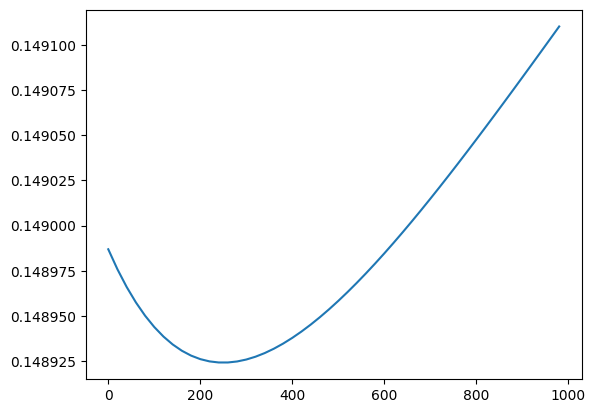

In [ ]:
test_n0('GM',0,1000,20)

In [ ]:
post_beta=bayes_capm(df[stock],df['SPY'],[0,1],350)
post_beta

array([-1.75819713e-04,  1.16938178e+00])

In [ ]:
post_beta=bayes_capm(df[stock],df['SPY'],[0,1],4000)
post_beta

array([-6.90939601e-05,  1.06656397e+00])

**Question:** What's wrong with this approach? \\

**Answer:** Data Partitioning. We may want to partition based on time instead of random for hyperparameter tuning

In [ ]:
df

,SPY,AAPL,META,IBM,PG,VXX,INTC,GM
Date,,,,,,,,
2013-01-03,-0.002259,-0.012622,-0.008214,-0.005500,-0.006341,NaN,-0.002806,0.023687
2013-01-04,0.004392,-0.027855,0.035650,-0.006555,0.002031,NaN,-0.007505,0.001342
2013-01-07,-0.002733,-0.005883,0.022949,-0.004382,-0.006803,NaN,0.004254,-0.006698
2013-01-08,-0.002878,0.002691,-0.012237,-0.001398,-0.001603,NaN,-0.007529,-0.009778
2013-01-09,0.002542,-0.015628,0.052650,-0.002851,0.005401,NaN,0.017070,0.020429
...,...,...,...,...,...,...,...,...
2020-12-23,0.000898,-0.006976,0.003819,0.002346,-0.001538,-0.040309,0.008664,0.037897
2020-12-24,0.003891,0.007712,-0.002648,0.006376,0.010122,-0.028769,0.010737,-0.020495
2020-12-28,0.008591,0.035766,0.035901,0.001043,0.006971,-0.003554,0.000000,0.001924


In [ ]:
bayes_capm(df['GM'],df['SPY'],[0,1],300)

array([-1.79620498e-04,  1.17304401e+00])

Let's try a Ridge model.  Ridge penaized parameters for being different from zero, so in our case we must reformulate the problem.  The regular CAPM is $$r_t=\alpha+\beta b_t+\epsilon_t$$ where $r_t$ is the return of the stock and $b_t$ is the return of the benchmark.  Reformulate to
$$(r_t-b_t)=\alpha+(\beta-1)b_t=\alpha+\tilde\beta b_t$$
so that stocks should not stray too far from the overall avaerage $\alpha=0$ and $\tilde\beta=0$.

So $\beta=\tilde\beta+1$

Again, you would want to optimize for alpha here

In [ ]:
#function to test which n0 to use for prior
def test_alpha_ridge(stock,alpha_start,alpha_end,alpha_by):
    num_experiments=500
    NN=len(df[stock])
    alpha_range=np.linspace(alpha_start,alpha_end,int((alpha_end-alpha_start)/alpha_by))
    error_sums=np.zeros(len(alpha_range))
    betas=np.zeros(len(alpha_range))
    intercept=np.zeros(len(alpha_range))
    shuffle_list=np.arange(NN)
    test=int(.7*NN)
    #run num_experiments different expiriments to reduce variance
    for iter in range(num_experiments):
        random.shuffle(shuffle_list)
        for alpha in range(len(alpha_range)):
            ridge_model = Ridge(alpha=alpha_range[alpha],max_iter=10000, tol=0.00001)
            #mutliplied by 100 to reduce floating point issues
            ridge_fit = ridge_model.fit(df[['SPY']].iloc[shuffle_list[:test]],(df[stock].iloc[shuffle_list[:test]]-df['SPY'].iloc[shuffle_list[:test]]))
            pred=(ridge_fit.intercept_)+(1+ridge_fit.coef_[0])*df['SPY']
            err=df[stock]-pred
            err=err.iloc[shuffle_list[test:]]
            error_sums[alpha]=error_sums[alpha]+err.T.dot(err)
            betas[alpha]+=(1+ridge_fit.coef_[0])
            intercept[alpha]+=(ridge_fit.intercept_)
    error_sums=error_sums/num_experiments
    betas=betas/num_experiments
    intercept=intercept/num_experiments
    print(intercept)
    print(betas)
    plt.plot(alpha_range,error_sums)
    return error_sums

[-0.00021419 -0.00021228 -0.00021043 -0.00020864 -0.00020691 -0.00020523
 -0.0002036  -0.00020202 -0.00020049 -0.00019899 -0.00019755 -0.00019614
 -0.00019477 -0.00019344 -0.00019214 -0.00019088 -0.00018966 -0.00018846
 -0.00018729]
[1.19728469 1.19408295 1.19098388 1.18798261 1.18507457 1.18225546
 1.17952124 1.17686813 1.17429255 1.17179116 1.16936077 1.16699839
 1.16470121 1.16246654 1.16029188 1.15817481 1.15611309 1.15410456
 1.15214719]


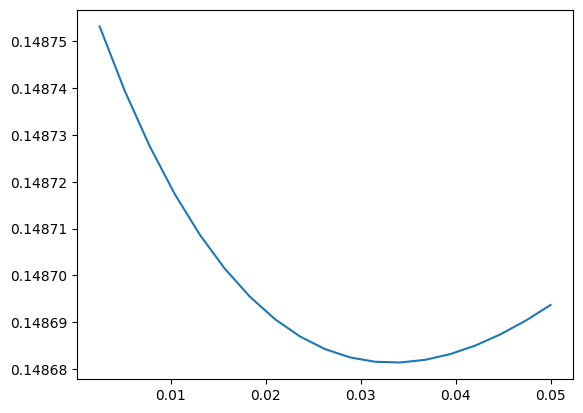

In [ ]:
#supress warnings just for this cell
import warnings
warnings.filterwarnings('ignore')
error_sums=test_alpha_ridge('GM',.0025,.05,.0025)

## What about Lasso regression?

In [ ]:
#function to test which n0 to use for prior
def test_alpha(stock,alpha_start,alpha_end,alpha_by):
    num_experiments=500
    NN=len(df[stock])
    alpha_range=np.linspace(alpha_start,alpha_end,int((alpha_end-alpha_start)/alpha_by))
    error_sums=np.zeros(len(alpha_range))
    betas=np.zeros(len(alpha_range))
    intercept=np.zeros(len(alpha_range))
    shuffle_list=np.arange(NN)
    test=int(.7*NN)
    #run num_experiments different expiriments to reduce variance
    for iter in range(num_experiments):
        random.shuffle(shuffle_list)
        for alpha in range(len(alpha_range)):
            lasso_model = Lasso(alpha=alpha_range[alpha],max_iter=10000, tol=0.0000001,selection='random')
            #multiply by 100 for floating point
            lasso_fit = lasso_model.fit(100.*df[['SPY']].iloc[shuffle_list[:test]],100.*(df[stock].iloc[shuffle_list[:test]]-df['SPY'].iloc[shuffle_list[:test]]))
            pred=(lasso_fit.intercept_/100.)+(1.+lasso_fit.coef_[0])*df['SPY']
            err=df[stock]-pred
            err=err.iloc[shuffle_list[test:]]
            error_sums[alpha]=error_sums[alpha]+err.T.dot(err)
            betas[alpha]+=(1+lasso_fit.coef_[0])
            intercept[alpha]+=(lasso_fit.intercept_/100.)
    error_sums=error_sums/num_experiments
    betas=betas/num_experiments
    intercept=intercept/num_experiments
    print(intercept)
    print(betas)
    plt.plot(alpha_range,error_sums)
    return error_sums

In [ ]:
import warnings
warnings.filterwarnings('ignore')

[-0.00021067 -0.00020765 -0.00020464 -0.00020162 -0.0001986  -0.00019558
 -0.00019257 -0.00018955 -0.00018653 -0.00018351 -0.0001805  -0.00017748
 -0.00017446 -0.00017145 -0.00016844 -0.00016544 -0.00016244 -0.00015944
 -0.00015646]
[1.19763605 1.19265125 1.18766646 1.18268166 1.17769686 1.17271207
 1.16772727 1.16274248 1.15775768 1.15277288 1.14778809 1.14280329
 1.1378185  1.13283923 1.12787272 1.12291084 1.11794983 1.11300312
 1.10807615]


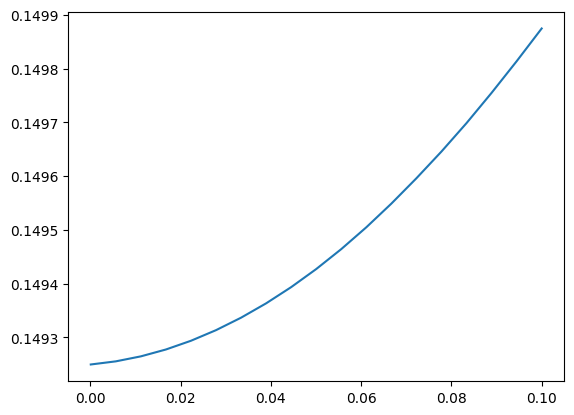

In [ ]:
error_sums=test_alpha('GM',.0001,.1,.005)

In [ ]:
#turn back on
warnings.filterwarnings('default')